<a href="https://colab.research.google.com/github/LuuZwide/PO-using-Actor-Critic/blob/main/Project_Actor_Critic(yFinance).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import yfinance as yf
drive.mount('/content/drive')
!cp "/content/drive/MyDrive/Functions/Preprocessing/Precossing_Functions_for_stock_chpters_1.ipynb" .
%run Precossing_Functions_for_stock_chpters_1.ipynb

from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC, LinearSVR, SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, roc_curve, precision_score, recall_score, precision_recall_curve,roc_auc_score
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, MaxAbsScaler

import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras import Model
import tensorflow_probability as tfp
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import tensorflow.keras.backend as K
from keras.activations import elu
from tensorflow.keras.initializers import HeNormal
import math
import datetime
from IPython.core.display import clear_output

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=700)
start_timestamp = int(start_date.timestamp())
end_timestamp = int(end_date.timestamp())
ticker = yf.Ticker('IBM')
data = ticker.history(start=start_timestamp, end=end_timestamp, interval="1h")
len(data)

3367

In [ ]:
data.reset_index(drop = False, inplace = True)
data = data.drop(['Dividends', 'Stock Splits'], axis = 1)
prices = data['Close']
stock_prices = prices
len_of_data = len(prices)
window_size = 5
stock_dataset = Combine_dataframes(data ,prices, window_size,len_of_data, fast = 12, slow = 26)
stock_dataset = stock_dataset.drop('next_close', axis = 1) # the next close price will be calculated with a neural net
chart = stock_dataset
chart = chart.reset_index(drop=True)
attribs = list(chart.columns)


macd:  Index(['MACD', 'Signal', 'Histogram'], dtype='object')
Index(['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume', 'moving_avg',
       'exm_avg', 'STOCHk_1_3_3', 'STOCHd_1_3_3', 'MACD', 'Signal',
       'Histogram'],
      dtype='object')


Sort out the predictor

In [ ]:
data_pipeline = Pipeline(
  (
    ('ConvertDataFrame', Add_Closing_Prices(5)),
  )
)
test = data_pipeline.fit_transform(chart)


In [ ]:
list(test.columns)

['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'moving_avg',
 'exm_avg',
 'STOCHk_1_3_3',
 'STOCHd_1_3_3',
 'MACD',
 'Signal',
 'Histogram',
 'Prev_Close_1',
 'Prev_Close_2',
 'Prev_Close_3',
 'Prev_Close_4',
 'Prev_Close_5']

In [ ]:
test.head()

,Open,High,Low,Close,Volume,moving_avg,exm_avg,STOCHk_1_3_3,STOCHd_1_3_3,MACD,Signal,Histogram,Prev_Close_1,Prev_Close_2,Prev_Close_3,Prev_Close_4,Prev_Close_5
0,136.529633,137.323135,136.376678,136.548752,535211,136.484570,136.449925,66.226859,75.920284,0.200599,0.158550,0.042049,136.524857,136.491394,136.443222,136.414627,136.328873
1,136.539200,136.878586,135.869980,136.029160,357739,136.407477,136.309527,40.427408,63.805889,0.170250,0.160944,0.009306,136.548752,136.524857,136.491394,136.443222,136.414627
2,136.003830,136.342361,135.936905,135.936905,265077,136.306213,136.185236,11.320980,39.325082,0.139475,0.156572,-0.017097,136.029160,136.548752,136.524857,136.491394,136.443222
3,135.927338,136.472275,135.908218,136.443588,261454,136.296652,136.271392,36.898798,29.549062,0.144502,0.154122,-0.009621,135.936905,136.029160,136.548752,136.524857,136.491394
4,136.443588,136.472275,136.147232,136.405350,285830,136.272751,136.316058,58.108210,35.442663,0.144185,0.152112,-0.007927,136.443588,135.936905,136.029160,136.548752,136.524857


In [ ]:
data_pipeline = Pipeline(
  (
    ('ConvertDataFrame', DataFrameSelector(attribs)),
    ('Scaler',MinMaxScaler())
  )
)
chart_df = data_pipeline.fit_transform(chart)
model = keras.models.load_model('/content/drive/MyDrive/Models/Prediction Model/Dense_pred.h5')
predictions = model.predict(chart_df)
print(predictions.shape)
print(chart.shape)
chart['Pred_Price'] = predictions

106/106 [==============================] - 0s 1ms/step
(3367, 1)
(3367, 13)


In [ ]:
# attribs = list(['Open', 'High', 'Low', 'Close', 'moving_avg', 'exm_avg','Pred_Price'])
attribs = list(['Prev_Close_1','Prev_Close_2','Prev_Close_3','Prev_Close_4', 'Prev_Close_5','Close','Pred_Price',])
#attribs =list(['Close','moving_avg','exm_avg','Prev_Close_1','Prev_Close_2','Prev_Close_3','Prev_Close_4', 'Prev_Close_5'])
chart.head(-50)

,Open,High,Low,Close,Volume,moving_avg,exm_avg,STOCHk_1_3_3,STOCHd_1_3_3,MACD,Signal,Histogram,Prev_Close_1,Pred_Price
0,134.761002,135.468445,134.435944,134.521988,0,0.000000,134.521988,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,128.035889
1,134.521988,135.047806,134.158707,134.990433,442066,0.000000,134.803055,0.000000,0.000000,0.009759,0.005422,0.004337,134.521988,127.800018
2,134.990433,135.009567,134.435944,134.732315,336984,0.000000,134.769547,51.182391,0.000000,0.004980,0.005241,-0.000261,134.990433,129.094055
3,134.722748,135.258133,134.665283,135.086044,270228,0.000000,134.901015,72.062078,0.000000,0.014565,0.008399,0.006166,134.732315,130.125198
4,135.086044,135.210327,134.923523,135.066925,204929,134.879541,134.964705,57.546391,60.263620,0.018734,0.011474,0.007260,135.086044,134.711975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3312,136.164993,136.339996,135.869995,136.035004,425443,135.826001,135.873566,42.713365,53.064000,0.698049,0.693421,0.004628,136.160004,135.644348
3313,136.035004,136.039993,135.860001,135.990005,374902,135.950003,135.912379,49.112285,48.697981,0.682022,0.691141,-0.009119,136.035004,135.623672
3314,135.990005,136.050003,135.839996,135.914993,372709,136.069000,135.913251,47.682558,46.502736,0.655612,0.684035,-0.028424,135.990005,135.597687
3315,135.911301,136.542999,135.910004,136.375000,603186,136.095001,136.067167,60.466404,52.420416,0.660953,0.679419,-0.018466,135.914993,136.048553


In [ ]:
# data_pipeline = Pipeline(
#   (
#     ('ConvertDataFrame', DataFrameSelector(attribs))
#   )
# )

In [ ]:
# og_chart = chart.values
# chart = data_pipeline.fit_transform(chart)

In [ ]:
chart

,Open,High,Low,Close,Volume,moving_avg,exm_avg,STOCHk_1_3_3,STOCHd_1_3_3,MACD,Signal,Histogram,Prev_Close_1,Pred_Price
0,134.761002,135.468445,134.435944,134.521988,0,0.000000,134.521988,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,128.035889
1,134.521988,135.047806,134.158707,134.990433,442066,0.000000,134.803055,0.000000,0.000000,0.009759,0.005422,0.004337,134.521988,127.800018
2,134.990433,135.009567,134.435944,134.732315,336984,0.000000,134.769547,51.182391,0.000000,0.004980,0.005241,-0.000261,134.990433,129.094055
3,134.722748,135.258133,134.665283,135.086044,270228,0.000000,134.901015,72.062078,0.000000,0.014565,0.008399,0.006166,134.732315,130.125198
4,135.086044,135.210327,134.923523,135.066925,204929,134.879541,134.964705,57.546391,60.263620,0.018734,0.011474,0.007260,135.086044,134.711975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3362,130.860001,131.080002,130.770004,130.919998,415786,131.784003,131.669524,28.425996,32.160727,-1.389869,-1.009074,-0.380795,130.860001,130.678757
3363,130.929993,131.070007,130.804993,131.059998,444346,131.254001,131.466349,53.051385,37.457982,-1.424756,-1.092210,-0.332546,130.919998,130.705963
3364,131.054993,131.378204,131.050003,131.195007,507672,131.023001,131.375902,62.929984,48.135789,-1.424409,-1.158650,-0.265759,131.059998,130.802673
3365,131.195007,131.315002,131.080002,131.169998,829939,131.041000,131.307267,59.566886,58.516085,-1.408455,-1.208611,-0.199844,131.195007,130.804321


In [ ]:
rewards = np.zeros(10)
x = 1.5
rewards[:10] = x
print(rewards)

[1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5]


In [ ]:
import math
import numpy as np

class Portfolio():
    def __init__(self, starting_amount):
        self.port_value = starting_amount
        self.prev_port_value = starting_amount
        self.starting_amount = starting_amount
        self.relative_vector = None
        self.prev_relative_vector = np.array([0, 0])
        self.prev_weights = np.array([0, 0])
        self.returns = []

    def update_port(self, weights, prev_closings, cur_closings):
        prev = np.hstack(([1], prev_closings))
        curr = np.hstack(([1], cur_closings))
        self.relative_vector = curr / prev
        pt = self.port_value * np.dot(self.relative_vector, weights)
        self.prev_port_value = self.port_value
        self.port_value = pt
        return self.port_value, self.relative_vector

    def calculate_return(self, relative_vector, weights):
        rate_return = np.dot(relative_vector, weights)
        if rate_return <= 0:
            return -1.0  # Negative return for loss
        log_rate_return = math.log(rate_return)
        self.returns.append(log_rate_return)
        return log_rate_return

    def calculate_reward(self, weights):
        price = self.relative_vector[1]
        self.prev_weights = np.array(self.prev_weights)
        rate_return = self.calculate_return(self.relative_vector, weights)
        price_change = price - self.prev_relative_vector[1]

        if rate_return > 0 and price_change > 0:
            reward = math.log(1 + rate_return)
        elif rate_return < 0 and price_change < 0:
            reward = -abs(math.log(1 + rate_return))
        else:
            reward = 0

        self.prev_weights = weights
        self.prev_relative_vector = self.relative_vector
        return reward

    def clear_returns(self):
        self.returns = []

class Env():

  def __init__(self, Portfolio, chart , closing_amounts, episode_length ): #add a model to my parameters
    self.chart = chart
    self.closing_amounts = closing_amounts
    self.portfolio = Portfolio
    self.episode_length = episode_length
    self.index = 0
    self.counter = 0 # Count the number of days the agent have been trading
    self.done = False
    self.trunc = False
    self.starting_amount = Portfolio.starting_amount
    self.trade_count = 0 # Number of times the agent has traded
    self.prev_porfolio_value = self.portfolio.port_value
    self.current_portfolio_value = self.portfolio.port_value
    self.returns = 0

  def reset(self): # Index is to deside when to start the trading period

    self.portfolio = Portfolio(self.starting_amount)
    self.index = random.randint(0, len(self.chart) - self.episode_length)
    #self.index = len(self.chart) - self.episode_length
    initial_weights = np.array([1, 0])
    self.counter = 0
    self.portfolio.prev_weights = [0,0]
    self.portfolio.clear_returns()
    self.state = self.add_gaussian_noise(self.chart[self.index])
    return self.state

  def add_gaussian_noise(self, state, mean = 0.0, std_dev = 0.1):
    noise = np.random.normal(mean, std_dev, size=state.shape)
    noisy_state = state + noise
    return noisy_state

  def check_done(self, portfolio_value):
    done = False
    threshhold =  portfolio_value/self.starting_amount
    if threshhold > 0.01:
      done = False
    else:
      done = True
    return done

  def check_trunc(self):
    if(self.counter > self.episode_length):
      return True
    else:
      return False

  def step(self, action ):

    if ((self.index + 1) < len(self.chart)):
      prev_closing = self.closing_amounts[self.index]
      cur_closing = self.closing_amounts[self.index + 1]
      self.prev_prev_porfolio_value = self.current_portfolio_value
      self.current_portfolio_value, relative_vector = self.portfolio.update_port(action, prev_closing, cur_closing)
      self.returns = self.portfolio.calculate_return(relative_vector, action)
      reward = self.portfolio.calculate_reward(action)
      next_state = self.chart[self.index]
      done = False
      trunc = False

    else:
      print('This should not happen')
      next_state = self.chart[self.index]
      done = True
      reward = 0

    if(self.check_done(self.current_portfolio_value)) is True:
      done = True
      next_state = self.chart[self.index]
      reward = reward
      trunc = False

    if(self.check_trunc() is True):
      trunc = True
      done = False
      reward = reward
      next_state = self.chart[self.index]



    self.counter = self.counter + 1
    self.next_state =  self.add_gaussian_noise(next_state)
    self.reward = reward
    self.done = done
    self.trunc = trunc
    self.index = self.index + 1

    return self.next_state, self.reward, self.done, self.trunc

In [ ]:
x = test[['Prev_Close_1','Prev_Close_2','Prev_Close_3','Prev_Close_4', 'Prev_Close_5','Close']]
x.head()

,Prev_Close_1,Prev_Close_2,Prev_Close_3,Prev_Close_4,Prev_Close_5,Close
0,136.524857,136.491394,136.443222,136.414627,136.328873,136.548752
1,136.548752,136.524857,136.491394,136.443222,136.414627,136.029160
2,136.029160,136.548752,136.524857,136.491394,136.443222,135.936905
3,135.936905,136.029160,136.548752,136.524857,136.491394,136.443588
4,136.443588,135.936905,136.029160,136.548752,136.524857,136.405350


In [ ]:
# # testing ENV

# portfolio = portfolio =  Portfolio(500)
# env = Env(portfolio, x.values, x['Close'].values, episode_length = 100)

# env.reset()

In [ ]:
# next_state, reward, done, trunc = env.step(np.array([0.1, 0.9]))
# print(next_state.shape)
# print(env.index)
# print(next_state)



In [ ]:
class PreprocessingModel:
  def __init__(self, input_dim, saved_location):
    self.input_dim = input_dim
    self.saved_location = saved_location
    self.normalisation_layer = self._build_normalisation_layer()

  def _build_normalisation_layer(self):
    return keras.layers.Normalization(axis = None)

  def preprocessing(self, x):
    return self.normalisation_layer(x)

  def adapt(self, x):
    self.normalisation_layer.adapt(x)

  def save_normalisation_layer(self):
    config = self.normalisation_layer.get_config()
    normalisation_layer = keras.layers.Normalization.from_config(config)
    normalisation_layer.build((None, self.input_dim))
    normalisation_layer.set_weights(self.normalisation_layer.get_weights())
    normalisation_layer.save_weights(self.saved_location)

  def load_normalisation_layer(self):
    self.normalisation_layer = keras.layers.Normalization()
    self.normalisation_layer.build((None, self.input_dim))
    self.normalisation_layer.load_weights(self.saved_location)

In [ ]:
# preprocessing = PreprocessingModel(6)

# test = np.expand_dims(x.values[1], axis = 1)
# preprocessing.normalisation_layer.adapt(test)
# print(preprocessing(test))


# preprocessing.save(filepath='/content/drive/MyDrive/Models/Preprocessing/')
# pr

In [ ]:
# next_state, reward, done, trunc = env.step(np.array([0.5 ,0.4]))


# print(next_state)
# preprocessing.adapt(next_state)

# p = preprocessing.preprocessing(next_state)

# print(p)

In [ ]:
class Actor(tf.keras.Model):
  def __init__(self, num_actions):
    super(Actor, self).__init__()
    self.num_actions = num_actions
    # add a normalisation layer mean = 0 and variance 1
    # layer = tf.layer.keras.layers.Normalization(axis = None)
    # call layer.adapt()
    self.dense_layer_one = keras.layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform')
    self.dense_layer_two = keras.layers.Dense(64, activation='relu', kernel_initializer='glorot_uniform')
    self.dense_layer_three = keras.layers.Dense(32, activation='relu', kernel_initializer='glorot_uniform')
    self.dense_layer_four = keras.layers.Dense(16, activation='relu', kernel_initializer='glorot_uniform')
    self.dense_layer_five = keras.layers.Dense(8, activation='relu', kernel_initializer='glorot_uniform')
    self.policy = keras.layers.Dense(self.num_actions, activation='softmax', kernel_initializer='glorot_uniform')

  def call(self, state):
    layer_one = self.dense_layer_one(state)
    layer_two = self.dense_layer_two(layer_one)
    layer_three = self.dense_layer_three(layer_two)
    layer_four = self.dense_layer_four(layer_three)
    layer_five = self.dense_layer_five(layer_four)
    actor = self.policy(layer_five)

    return actor


In [ ]:
class Critic(tf.keras.Model):
  def __init__(self,state_shape):
    super(Critic,self).__init__()
    # add a normalisation layer mean = 0 and variance 1
    self.dense_layer_one = keras.layers.Dense(128, activation = 'relu')
    self.dense_layer_two = keras.layers.Dense(64, activation = 'relu')
    self.dense_layer_three = keras.layers.Dense(32, activation = 'relu')
    self.dense_layer_four = keras.layers.Dense(16, activation = 'relu')
    self.dense_layer_five = keras.layers.Dense(8, activation = 'relu')
    self.vfunc = keras.layers.Dense(1)

  def call(self, states,actions):
    state = tf.concat([states, actions], axis = 1)
    layer_one = self.dense_layer_one(state)
    layer_two = self.dense_layer_two(layer_one)
    layer_three = self.dense_layer_three(layer_two)
    layer_four = self.dense_layer_four(layer_three)
    layer_five = self.dense_layer_five(layer_four)
    v_value = self.vfunc(layer_five)

    return v_value

In [ ]:
class ReplayBuffer():
  def __init__(self, max_size, input_shape, num_actions):
    self.max_size = max_size
    self.input_shape = input_shape
    self.num_actions = num_actions
    self.preprocessed_state_memory = np.zeros((self.max_size, input_shape))
    self.state_memory = np.zeros((self.max_size, input_shape))
    self.action_memory = np.zeros((self.max_size, num_actions))
    self.reward_memory = np.zeros(self.max_size)
    self.next_state_memory = np.zeros((self.max_size, input_shape))
    self.terminal_memory= np.zeros(self.max_size, dtype = np.float32)
    self.mem_counter = 1

  def store_transitions(self, preprocessed_state,state, action, reward, done):
    index = self.mem_counter % self.max_size
    self.preprocessed_state_memory[index] = preprocessed_state
    self.state_memory[index] = state
    self.action_memory[index] = action
    self.reward_memory[index] = reward
    self.terminal_memory[index] = 1 - int(done) #False = 0 , True = 1 Cause if the state is done G will 0 cause the are no future rewards
    if self.mem_counter > 0 :
      self.next_state_memory[index - 1] = preprocessed_state

    self.mem_counter += 1

  def sample(self, batch_size):
    start_range = min(self.mem_counter, self.max_size)
    start_index = random.randint(0, start_range - batch_size)
    end_index = start_index + batch_size

    preprocessed_states = self.preprocessed_state_memory[start_index : end_index]
    states = self.state_memory[start_index : end_index]
    actions = self.action_memory[start_index : end_index]
    rewards = self.reward_memory[start_index : end_index]
    next_states = self.next_state_memory[start_index : end_index]
    dones = self.terminal_memory[start_index : end_index]

    return preprocessed_states,states, actions, rewards, next_states,dones

  def back_sample(self, batch_size):
    start_index = 0
    end_index = batch_size

    states = self.state_memory[start_index : end_index]
    actions = self.action_memory[start_index : end_index]
    rewards = self.reward_memory[start_index : end_index]
    next_states = self.next_state_memory[start_index : end_index]
    dones = self.terminal_memory[start_index : end_index]

    return states, actions, rewards, next_states,dones

  def random_sample(self, batch_size):
    mem_size = min(self.mem_counter, self.max_size)
    batch = np.random.choice(mem_size, batch_size)
    preprocessed_states = self.preprocessed_state_memory[batch]
    states = self.state_memory[batch]
    actions = self.action_memory[batch]
    rewards = self.reward_memory[batch]
    next_states = self.next_state_memory[batch]
    dones = self.terminal_memory[batch]

    return preprocessed_states,states, actions, rewards, next_states,dones

  def clear_memory(self):
    self.preprocessed_state_memory = np.zeros((self.max_size, self.input_shape))
    self.state_memory = np.zeros((self.max_size, self.input_shape))
    self.action_memory = np.zeros((self.max_size, self.num_actions))
    self.reward_memory = np.zeros(self.max_size)
    self.next_state_memory = np.zeros((self.max_size, self.input_shape))
    self.terminal_memory= np.zeros(self.max_size, dtype = np.float32)
    self.mem_counter = 1



In [ ]:
class Agent():
  def __init__(self,num_actions, state_shape, gamma, Policy_lr,value_func_lr, max_mem_size,
               batch_size, num_batches, tau, save_location,
               preprocessor):
    self.num_batches = num_batches
    self.num_actions = num_actions
    self.tau = tau
    self.state_shape = state_shape
    self.gamma = gamma
    self.max_grad_norm = 1.5
    self.Policy_lr = Policy_lr
    self.value_func_lr = value_func_lr
    self.max_mem_size = max_mem_size
    self.batch_size = batch_size
    self.preprocessor = preprocessor

    self.Actor = Actor(self.num_actions)
    self.Actor.compile(optimizer = keras.optimizers.Adam(learning_rate = self.Policy_lr))
    self.Target_Actor = Actor(self.num_actions)
    self.Target_Actor.compile(optimizer = keras.optimizers.Adam(learning_rate = self.Policy_lr))

    self.Critic = Critic(state_shape)
    self.Critic.compile(optimizer = keras.optimizers.Adam(learning_rate = self.value_func_lr))
    self.Target_Critic = Critic(state_shape)
    self.Target_Critic.compile(optimizer = keras.optimizers.Adam(learning_rate = self.value_func_lr))

    self.memory = ReplayBuffer(self.max_mem_size, self.state_shape, self.num_actions)
    self.learn_counter  = 0

    self.save_location = save_location
    self.act_loc = self.save_location + 'ctor'
    self.cri_loc = self.save_location + 'critic'
    self.target_act_loc = self.save_location + 'target_actor'
    self.target_cri_loc = self.save_location + 'target_critic'
    self.mu = 0  # Mean of the noise
    self.sigma = 0.1  # Standard deviation of the noise
    self.theta = 0.15  # Parameter for the Ornstein-Uhlenbeck process
    self.dt = 1e-2  # Time step size for the Ornstein-Uhlenbeck process
    self.noise_scale = 1.0

  def add_noise(self,action):
    noise = np.zeros(self.num_actions)
    noise_process = np.zeros(self.num_actions)

    noise_process = self.theta * (self.mu - noise) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.num_actions)
    noise = self.noise_scale * noise_process
    noisy_action = action + noise
    self.noise_scale *= 0.99
    return noisy_action

  def choose_action(self, state):
    preprocessed_state = self.preprocessor.preprocessing(state)
    self.preprocessor.adapt(state)
    state = tf.convert_to_tensor([preprocessed_state])
    weights = self.Actor(state)
    noisy_weights = self.add_noise(weights)  # Add noise to the actor's actions
    return noisy_weights.numpy()[0], preprocessed_state

  def update_memory(self,preprocessed_state,state, action, reward, done):
    self.memory.store_transitions(preprocessed_state,state, action , reward, done)

  def save_models(self):
    print('...saving models...')
    self.Actor.save_weights(self.act_loc)
    self.Critic.save_weights(self.cri_loc)
    self.Target_Actor.save_weights(self.target_act_loc)
    self.Target_Critic.save_weights(self.target_cri_loc)

  def load_models(self):
    print('...load model....')
    self.Actor.load_weights(self.act_loc)
    self.Critic.load_weights(self.cri_loc)
    self.Target_Actor.load_weights(self.target_act_loc)
    self.Target_Critic.load_weights(self.target_cri_loc)


  def Update_net_parameters(self):
    tau = self.tau

    actor_weights = []
    targets_actor_weights = self.Target_Actor.weights
    for i,weight in enumerate(self.Actor.weights):
      updated_weights = weight * tau + (1 - tau)*targets_actor_weights[i]
      actor_weights.append(updated_weights)
    self.Target_Actor.set_weights(actor_weights)

    critic_weights = []
    targets_critic_weights = self.Target_Critic.weights
    for i,weight in enumerate(self.Critic.weights):
      update_weights = weight * tau + (1 - tau)*targets_critic_weights[i]
      critic_weights.append(update_weights)
    self.Target_Critic.set_weights(critic_weights)


  def learn(self):

    if self.memory.mem_counter < self.batch_size:
      return -10, -10
    else:
      self.learn_counter += 1
      preprocessed_state,states, actions, rewards, next_states, dones = self.memory.random_sample(self.batch_size)
      #self.memory.clear_memory()
      actions = tf.cast(actions, dtype=tf.float32)

      with tf.GradientTape() as tape:
        target_actions = self.Target_Actor(next_states)
        target_value_func = self.Target_Critic(next_states,target_actions)
        y = tf.cast(tf.expand_dims(rewards, axis=-1), dtype=tf.float32) + self.gamma*target_value_func * tf.cast(tf.expand_dims(1 - dones, axis=-1), dtype=tf.float32)
        value_func = self.Critic(preprocessed_state, actions)
        critic_loss = tf.losses.mean_squared_error(y, value_func)

      critic_gradients = tape.gradient(critic_loss, self.Critic.trainable_variables)
      critic_gradients = [tf.clip_by_norm(grad, self.max_grad_norm) for grad in critic_gradients]
      self.Critic.optimizer.apply_gradients(zip(critic_gradients, self.Critic.trainable_variables))

      with tf.GradientTape() as tape:
        current_actions = self.Actor(preprocessed_state)
        actor_loss = self.Critic(preprocessed_state, current_actions)
        actor_loss = -1 * tf.reduce_mean(actor_loss)

      actor_gradients = tape.gradient(actor_loss, self.Actor.trainable_variables)
      actor_gradients = [tf.clip_by_norm(grad, self.max_grad_norm) for grad in actor_gradients]
      self.Actor.optimizer.apply_gradients(zip(actor_gradients, self.Actor.trainable_variables))

    if (self.learn_counter % 50 == 0):
      self.Update_net_parameters()

      self.learn_counter = 0
    return actor_loss, critic_loss


In [ ]:
episode_length = 160
starting_amount = 500
portfolio =  Portfolio(starting_amount )
preprocesing_model = PreprocessingModel(6, '/content/drive/MyDrive/Models/Preprocessing/')
chart = chart
action_size = 2 # We are dealing with 1 stock and the cash
state_size = 6
print(state_size)
layer_size1 = 1024
layer_size2 = 512
learning_rate = 1e-5
vf_learning_rate = 1e-5
num_episodes = 1000
gamma = 0.95
batch_size = episode_length
env = Env(portfolio, x.values, x['Close'].values, episode_length = episode_length)
agent = Agent(num_actions = action_size, state_shape = state_size, gamma = gamma,
              Policy_lr = learning_rate,value_func_lr = vf_learning_rate
              , max_mem_size = 20000, batch_size = 64,
              num_batches = 10, tau = 0.001, save_location= '/content/drive/MyDrive/Models/Test Actor Critic/',
              preprocessor = preprocesing_model)

6


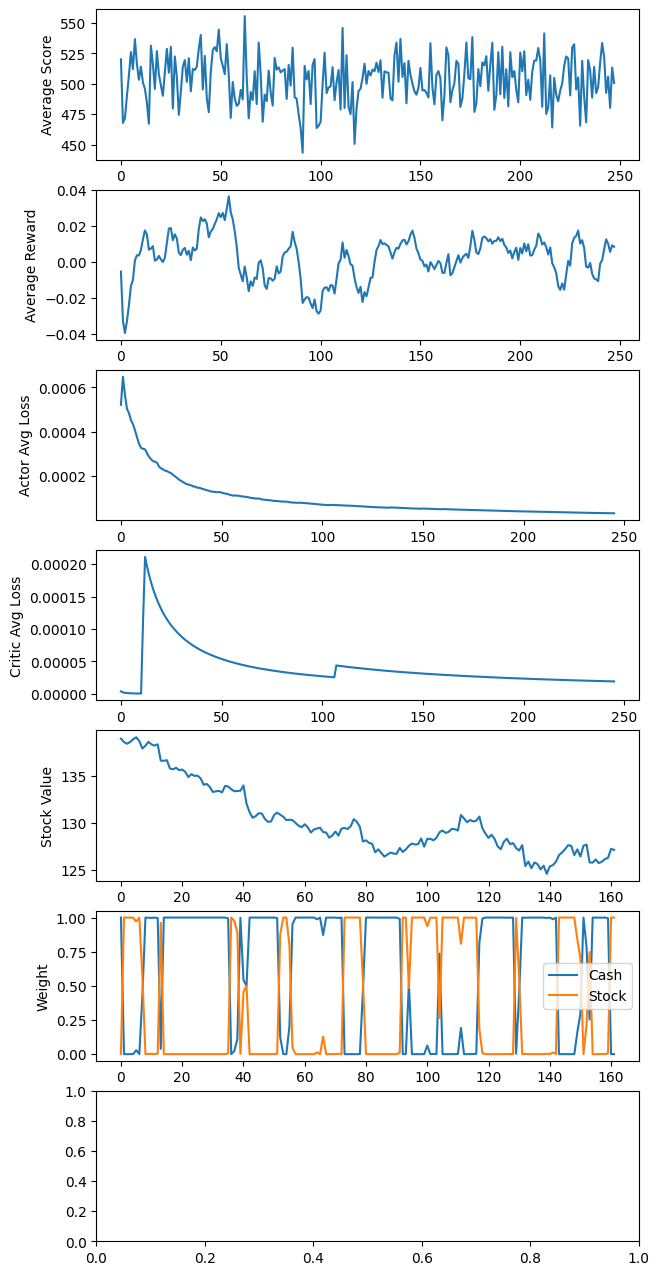

trunc: 506.9000428677502


In [ ]:

avg_scores = []
avg_rewards = []
avg_reward_history = []
scores = 0
rewards = 0
score_history = []
reward_history = []
actor_loss_history = []
critic_loss_history = []
actor_avg_lesses = []
critic_avg_lesses = []


buy_counts = []
cash_counts = []
stock_values = []
weights_history = []
starting_indices = []
cash_history = []
avg_cash_history = []
high_score = 0
agent.load_models()

for e in range(num_episodes):
    weights_history = []
    highest = 0
    state = env.reset()
    scores = 0
    rewards = 0
    done, trunc = (False, False)
    buy_count = 0
    cash_count = 0
    starting_index = env.index
    #agent.preprocessor.adapt(state)
    while not (trunc):
        action, preprocessed_state = agent.choose_action(state)
        next_state, reward, done, trunc = env.step(action)
        rewards += reward
        agent.update_memory(preprocessed_state,state, action, 0, done)
        actor_loss,critic_loss  =  agent.learn()
        state = next_state
        weights_history.append(action)
        if (env.current_portfolio_value > highest):
          highest = env.current_portfolio_value
    else:
      print('trunc:',env.current_portfolio_value)



    score_history.append(env.current_portfolio_value)
    avg_scores.append(env.current_portfolio_value)

    avg_reward_history.append(rewards)
    avg_reward = np.mean(avg_reward_history[-10:])
    avg_rewards.append(avg_reward)


    if (avg_reward > high_score) & (e > 10) :
      high_score = avg_reward
      agent.save_models()
    # else:
    #   agent.load_models()

    if e > 1 :
      actor_loss_history.append(actor_loss)
      avg_loss = np.mean(actor_loss_history)
      actor_avg_lesses.append(avg_loss)

      critic_loss_history.append(critic_loss)
      avg_loss = np.mean(critic_loss_history)
      critic_avg_lesses.append(avg_loss)

    buy_counts.append(buy_count)
    cash_counts.append(cash_count)

    if  e > 10:
        clear_output(wait=True)
        fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(7, 16))
        ax[0].plot(avg_scores)
        ax[0].set_xlabel('Episodes')
        ax[0].set_ylabel('Average Score')

        ax[1].plot(avg_rewards)
        ax[1].set_xlabel('Episodes')
        ax[1].set_ylabel('Average Reward')

        ax[2].plot(actor_avg_lesses)
        ax[2].set_xlabel('Episodes')
        ax[2].set_ylabel('Actor Avg Loss')

        ax[3].plot(critic_avg_lesses)
        ax[3].set_xlabel('Episodes')
        ax[3].set_ylabel('Critic Avg Loss')

        ax[4].plot(x['Close'].values[starting_index:env.index])
        ax[4].set_xlabel('Steps')
        ax[4].set_ylabel('Stock Value')

        ax[5].plot(weights_history)
        ax[5].set_xlabel('Steps')
        ax[5].set_ylabel('Weight')
        ax[5].legend(['Cash', 'Stock'])

        plt.show()

In [ ]:

avg_scores = []
avg_rewards = []
avg_reward_history = []
scores = 0
rewards = 0
score_history = []
reward_history = []


buy_counts = []
cash_counts = []
stock_values = []
weights_history = []
high_score = 0
agent.load_models()

for e in range(1):
    weights_history = []
    highest = 0
    state = env.reset()
    scores = 0
    rewards = 0
    done, trunc = (False, False)
    buy_count = 0
    cash_count = 0
    starting_index = env.index
    #agent.preprocessor.adapt(state)
    while not (trunc):
        action, preprocessed_state = agent.choose_action(state)
        agent.preprocessor.adapt(state)
        next_state, reward, done, trunc = env.step(action)
        rewards += reward
        state = next_state
        weights_history.append(action)
        if (env.current_portfolio_value > highest):
          highest = env.current_portfolio_value
    else:
      print('trunc:',env.current_portfolio_value)

    score_history.append(env.current_portfolio_value)
    avg_scores.append(env.current_portfolio_value)

    buy_counts.append(buy_count)
    cash_counts.append(cash_count)

    fig, ax = plt.subplots(nrows=2, ncols=1)

    ax[0].plot(x['Close'].values[starting_index:env.index])
    ax[0].set_xlabel('Steps')
    ax[0].set_ylabel('Stock Value')

    ax[1].plot(weights_history)
    ax[1].set_xlabel('Steps')
    ax[1].set_ylabel('Weight')
    ax[1].legend(['Cash', 'Stock'])

    plt.show()